In [1]:
# ============================================
# SETUP CELL - Run this first after pod restart
# ============================================

import os
import sys

# Add workspace packages to Python path
workspace_packages = '/workspace/python_packages'
if workspace_packages not in sys.path:
    sys.path.insert(0, workspace_packages)

# Redirect all caches to persistent workspace storage
os.environ['HF_HOME'] = '/workspace/.cache/huggingface'
os.environ['TRANSFORMERS_CACHE'] = '/workspace/.cache/huggingface/transformers'
os.environ['HF_DATASETS_CACHE'] = '/workspace/.cache/huggingface/datasets'
os.environ['TORCH_HOME'] = '/workspace/.cache/torch'
os.environ['PIP_CACHE_DIR'] = '/workspace/.cache/pip'
os.environ['TMPDIR'] = '/workspace/tmp'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

# Create directories if they don't exist
for path in ['/workspace/.cache/huggingface', '/workspace/.cache/torch', 
             '/workspace/.cache/pip', '/workspace/tmp']:
    os.makedirs(path, exist_ok=True)

print("✓ Environment configured - all paths point to /workspace")

# Import your libraries
from typing import Optional, Tuple, List, Dict, Any
import numpy as np
import torch
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from ripser import ripser
from persim import plot_diagrams, bottleneck
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import json
import pickle
from pathlib import Path
from datetime import datetime
import hashlib
from scipy.stats import gaussian_kde
from scipy.spatial.distance import directed_hausdorff
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Environment configured - all paths point to /workspace


/workspace/python_packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


✓ All libraries imported successfully
PyTorch version: 2.3.1+cu118
CUDA available: True


In [2]:
"""
H2 Experimental Pipeline
Compute higher-dimensional persistence (H2) separately from existing H0/H1 results
"""

def compute_h2_from_saved_distances(exp_dir: Path, condition: str = "sandbagging",
                                   save_results: bool = True):
    """
    Compute H2 persistence from already-saved distance matrices
    This is MUCH faster than re-running the model!
    
    Args:
        exp_dir: Experiment directory with saved distance matrices
        condition: "sandbagging" or "non_sandbagging"
        save_results: Whether to save H2 results
        
    Returns:
        List of results with H2 diagrams added
    """
    condition_dir = exp_dir / condition
    
    print(f"Loading distance matrices from: {condition_dir}")
    
    # Load existing distance matrices
    Ds = np.load(condition_dir / "distance_matrices.npy", allow_pickle=True)
    
    # Load existing persistence diagrams
    with open(condition_dir / "persistence_diagrams.pkl", "rb") as f:
        res_list_original = pickle.load(f)
    
    print(f"✓ Loaded {len(Ds)} distance matrices")
    print(f"Computing H2 persistence (this may take a while)...")
    
    # Recompute with maxdim=2
    res_list_h2 = []
    for i, D in enumerate(Ds):
        if i % 10 == 0:
            print(f"  Processing {i+1}/{len(Ds)}...")
        
        # Compute with H2
        D_float32 = D.astype(np.float32)
        result = ripser(D_float32, maxdim=2, distance_matrix=True)
        res_list_h2.append(result)
    
    print(f"✓ H2 computation complete!")
    
    # Save H2 results separately
    if save_results:
        h2_dir = condition_dir / "h2_experimental"
        h2_dir.mkdir(exist_ok=True)
        
        with open(h2_dir / "persistence_diagrams_h2.pkl", "wb") as f:
            pickle.dump(res_list_h2, f)
        
        # Save metadata
        metadata = {
            "computed_at": datetime.now().isoformat(),
            "maxdim": 2,
            "n_samples": len(res_list_h2),
            "source": "recomputed from distance matrices"
        }
        with open(h2_dir / "metadata.json", "w") as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✓ Saved H2 results to: {h2_dir}")
    
    return res_list_h2


# ==============================================================================
# H2 VISUALIZATION UTILITIES
# ==============================================================================

def visualize_h2_sample(res_list_s, res_list_n, sample_idx: int = 0):
    """
    Visualize H0, H1, H2 side by side
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for dim in range(3):
        ax = axes[dim]
        
        dgm_s = res_list_s[sample_idx]['dgms'][dim]
        dgm_n = res_list_n[sample_idx]['dgms'][dim]
        
        # Plot sandbagging
        if len(dgm_s) > 0:
            finite_s = dgm_s[np.isfinite(dgm_s).all(axis=1)]
            if len(finite_s) > 0:
                ax.scatter(finite_s[:, 0], finite_s[:, 1],
                          label='Sandbagging', alpha=0.7, s=50)
        
        # Plot non-sandbagging
        if len(dgm_n) > 0:
            finite_n = dgm_n[np.isfinite(dgm_n).all(axis=1)]
            if len(finite_n) > 0:
                ax.scatter(finite_n[:, 0], finite_n[:, 1],
                          label='Non-sandbagging', alpha=0.7, marker='^', s=50)
        
        # Determine limits
        all_points = []
        if len(dgm_s) > 0:
            all_points.append(dgm_s[np.isfinite(dgm_s).all(axis=1)])
        if len(dgm_n) > 0:
            all_points.append(dgm_n[np.isfinite(dgm_n).all(axis=1)])
        
        if all_points and any(len(p) > 0 for p in all_points):
            all_points = np.vstack([p for p in all_points if len(p) > 0])
            xlim = (all_points[:, 0].min(), all_points[:, 0].max())
            ylim = (all_points[:, 1].min(), all_points[:, 1].max())
            ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k--', alpha=0.3)
        else:
            xlim, ylim = (0, 1), (0, 1)
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
        ax.set_title(f'H{dim} Persistence')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Persistence Diagrams with H2 - Sample {sample_idx}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def analyze_h2_statistics(res_list):
    """
    Analyze H2 features across samples
    """
    h2_stats = []
    
    for res in res_list:
        dgm = res['dgms'][2]
        
        finite_dgm = dgm[np.isfinite(dgm).all(axis=1)]
        
        if len(finite_dgm) > 0:
            lifespans = finite_dgm[:, 1] - finite_dgm[:, 0]
            h2_stats.append({
                'n_features': len(dgm),
                'n_finite': len(finite_dgm),
                'mean_lifespan': np.mean(lifespans),
                'max_lifespan': np.max(lifespans),
                'total_persistence': np.sum(lifespans)
            })
        else:
            h2_stats.append({
                'n_features': 0,
                'n_finite': 0,
                'mean_lifespan': 0,
                'max_lifespan': 0,
                'total_persistence': 0
            })
    
    # Print summary
    print(f"\n📊 H2 Statistics Summary:")
    print(f"  Total samples: {len(res_list)}")
    print(f"  Samples with H2 features: {sum(s['n_features'] > 0 for s in h2_stats)}")
    print(f"  Average H2 features: {np.mean([s['n_features'] for s in h2_stats]):.2f}")
    print(f"  Max H2 features: {max(s['n_features'] for s in h2_stats)}")
    print(f"  Average H2 lifespan: {np.mean([s['mean_lifespan'] for s in h2_stats if s['n_features'] > 0]):.4f}")
    
    return h2_stats


EXAMPLE 1: Recompute H2 from Saved Distance Matrices
This is the FASTEST method - uses already computed distance matrices

Loading distance matrices from: /workspace/experiments/bert-base-uncased_bert_roberta/sandbagging
✓ Loaded 20 distance matrices
Computing H2 persistence (this may take a while)...
  Processing 1/20...
  Processing 11/20...
✓ H2 computation complete!
✓ Saved H2 results to: /workspace/experiments/bert-base-uncased_bert_roberta/sandbagging/h2_experimental
Loading distance matrices from: /workspace/experiments/bert-base-uncased_bert_roberta/non_sandbagging
✓ Loaded 10 distance matrices
Computing H2 persistence (this may take a while)...
  Processing 1/10...
✓ H2 computation complete!
✓ Saved H2 results to: /workspace/experiments/bert-base-uncased_bert_roberta/non_sandbagging/h2_experimental


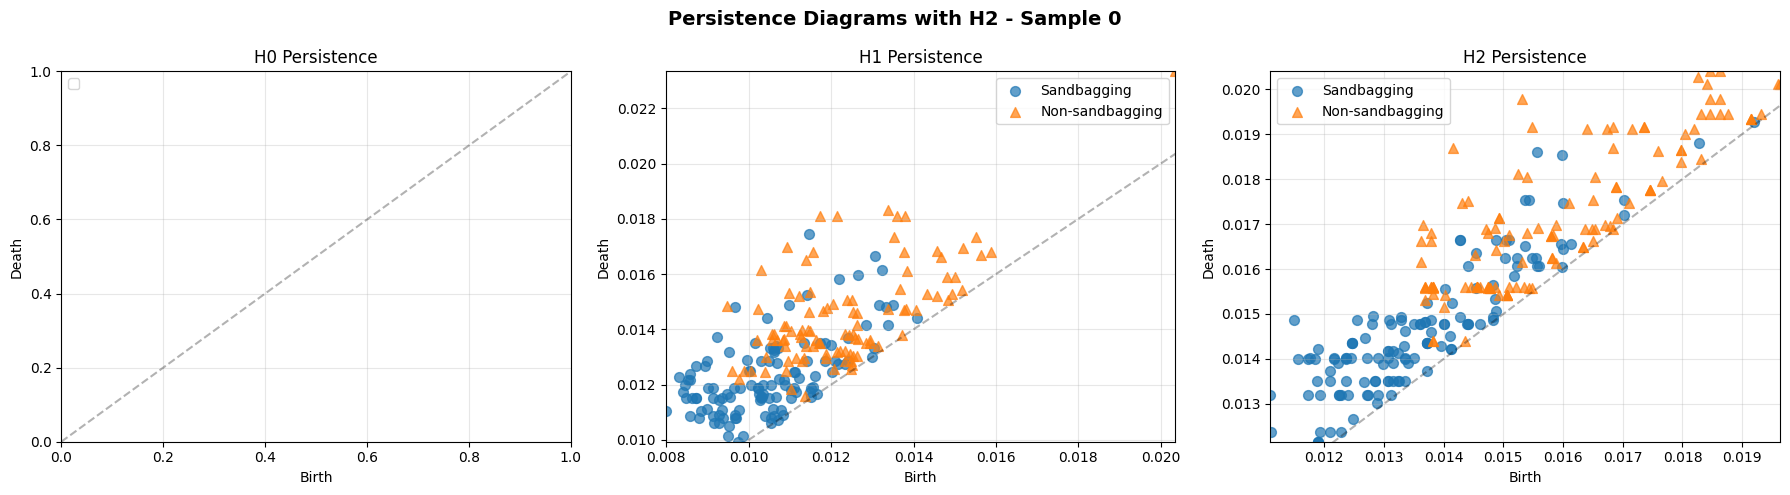


Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 20
  Samples with H2 features: 20
  Average H2 features: 1080.05
  Max H2 features: 5034
  Average H2 lifespan: 0.0008

Non-Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 10
  Samples with H2 features: 10
  Average H2 features: 735.00
  Max H2 features: 3181
  Average H2 lifespan: 0.0010
EXAMPLE 1: Recompute H2 from Saved Distance Matrices
This is the FASTEST method - uses already computed distance matrices

Loading distance matrices from: /workspace/experiments/distilbert-base-uncased/sandbagging
✓ Loaded 20 distance matrices
Computing H2 persistence (this may take a while)...
  Processing 1/20...
  Processing 11/20...
✓ H2 computation complete!
✓ Saved H2 results to: /workspace/experiments/distilbert-base-uncased/sandbagging/h2_experimental
Loading distance matrices from: /workspace/experiments/distilbert-base-uncased/non_sandbagging
✓ Loaded 10 distance matrices
Computing H2 persistence (this may take a while)..

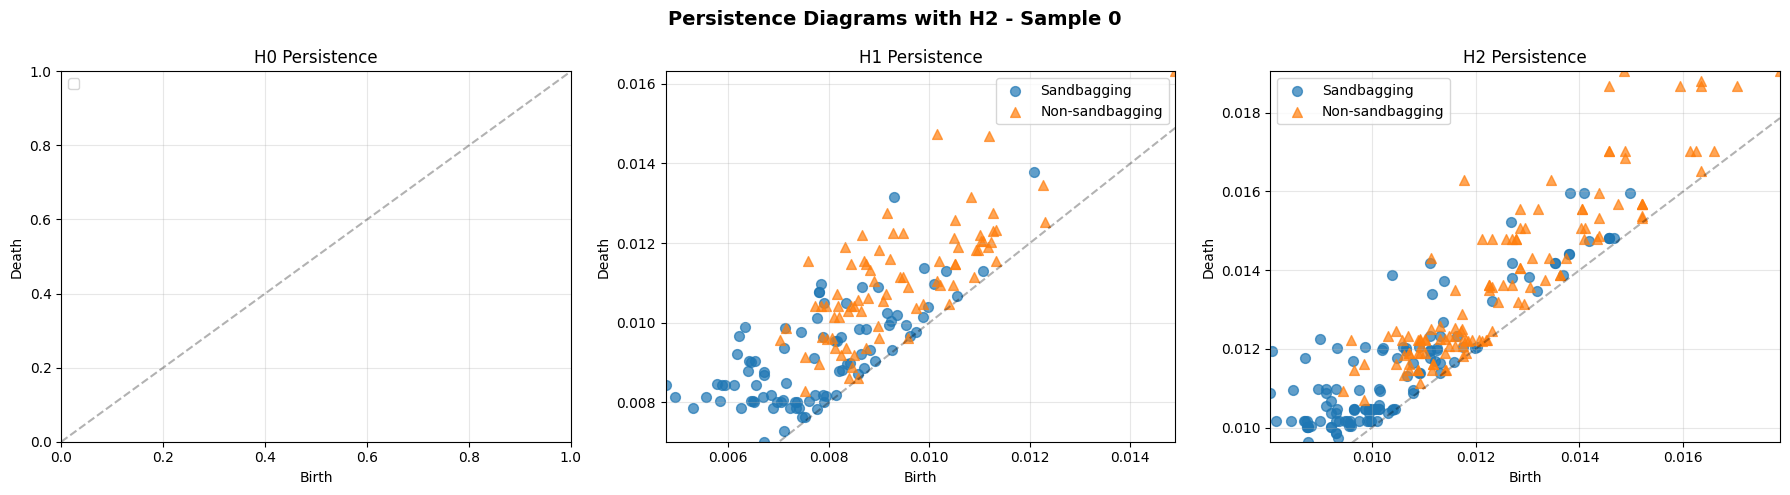


Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 20
  Samples with H2 features: 20
  Average H2 features: 830.30
  Max H2 features: 4231
  Average H2 lifespan: 0.0007

Non-Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 10
  Samples with H2 features: 10
  Average H2 features: 600.40
  Max H2 features: 3046
  Average H2 lifespan: 0.0009
EXAMPLE 1: Recompute H2 from Saved Distance Matrices
This is the FASTEST method - uses already computed distance matrices

Loading distance matrices from: /workspace/experiments/distilgpt2/sandbagging
✓ Loaded 20 distance matrices
Computing H2 persistence (this may take a while)...
  Processing 1/20...
  Processing 11/20...
✓ H2 computation complete!
✓ Saved H2 results to: /workspace/experiments/distilgpt2/sandbagging/h2_experimental
Loading distance matrices from: /workspace/experiments/distilgpt2/non_sandbagging
✓ Loaded 10 distance matrices
Computing H2 persistence (this may take a while)...
  Processing 1/10...
✓ H2 computation 

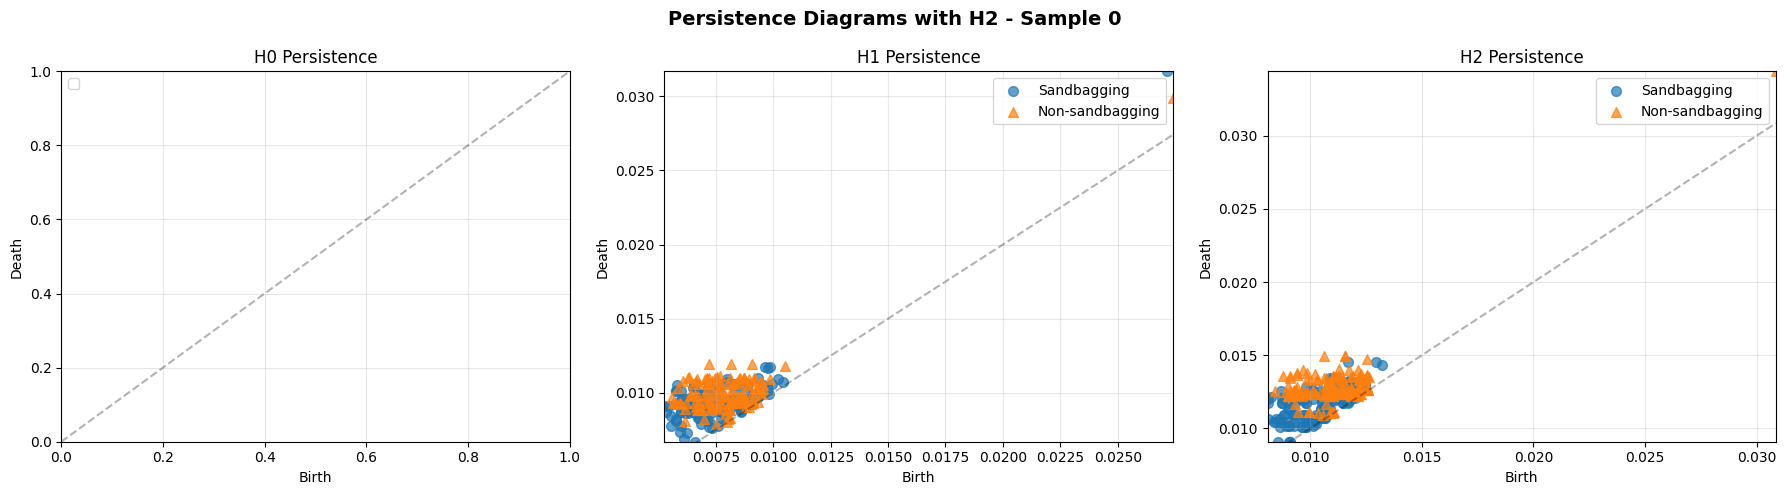


Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 20
  Samples with H2 features: 20
  Average H2 features: 2351.15
  Max H2 features: 13278
  Average H2 lifespan: 0.0009

Non-Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 10
  Samples with H2 features: 10
  Average H2 features: 1487.80
  Max H2 features: 7100
  Average H2 lifespan: 0.0012
EXAMPLE 1: Recompute H2 from Saved Distance Matrices
This is the FASTEST method - uses already computed distance matrices

Loading distance matrices from: /workspace/experiments/google_electra-small-discriminator/sandbagging
✓ Loaded 20 distance matrices
Computing H2 persistence (this may take a while)...
  Processing 1/20...
  Processing 11/20...
✓ H2 computation complete!
✓ Saved H2 results to: /workspace/experiments/google_electra-small-discriminator/sandbagging/h2_experimental
Loading distance matrices from: /workspace/experiments/google_electra-small-discriminator/non_sandbagging
✓ Loaded 10 distance matrices
Computing H2 pe

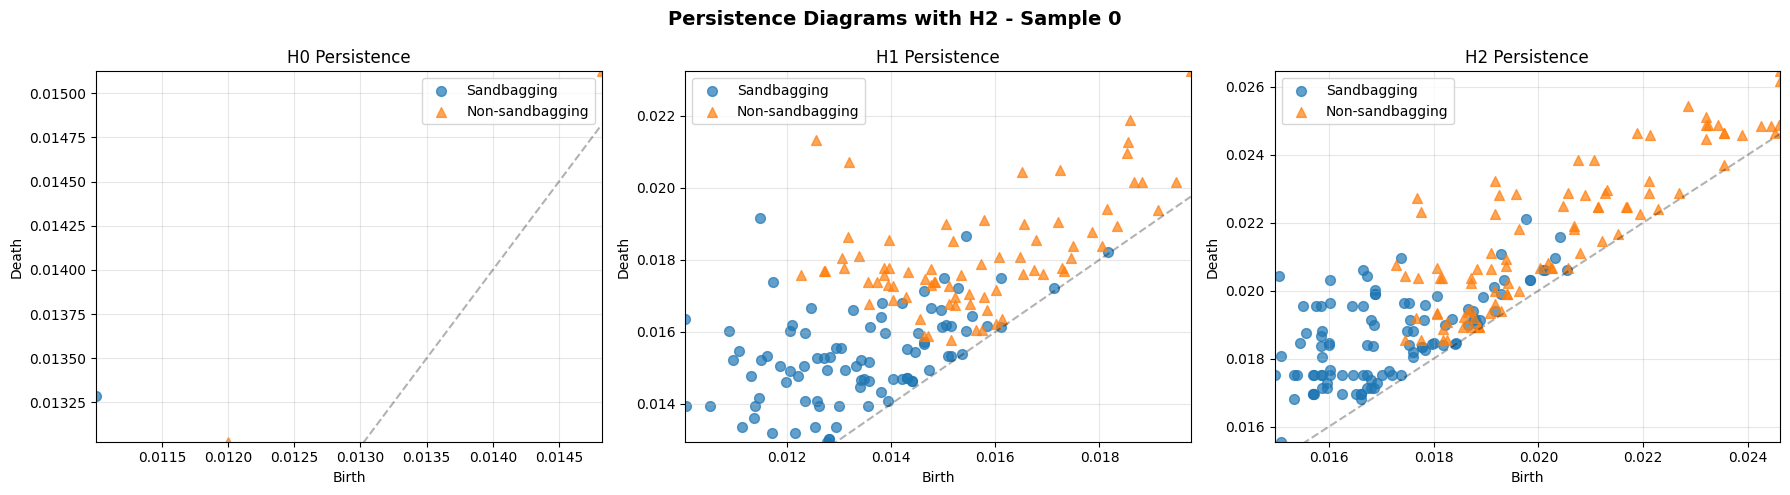


Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 20
  Samples with H2 features: 20
  Average H2 features: 762.70
  Max H2 features: 3922
  Average H2 lifespan: 0.0009

Non-Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 10
  Samples with H2 features: 10
  Average H2 features: 526.20
  Max H2 features: 2320
  Average H2 lifespan: 0.0011
EXAMPLE 1: Recompute H2 from Saved Distance Matrices
This is the FASTEST method - uses already computed distance matrices

Loading distance matrices from: /workspace/experiments/roberta-base_bert_roberta/sandbagging
✓ Loaded 20 distance matrices
Computing H2 persistence (this may take a while)...
  Processing 1/20...
  Processing 11/20...
✓ H2 computation complete!
✓ Saved H2 results to: /workspace/experiments/roberta-base_bert_roberta/sandbagging/h2_experimental
Loading distance matrices from: /workspace/experiments/roberta-base_bert_roberta/non_sandbagging
✓ Loaded 10 distance matrices
Computing H2 persistence (this may take a whi

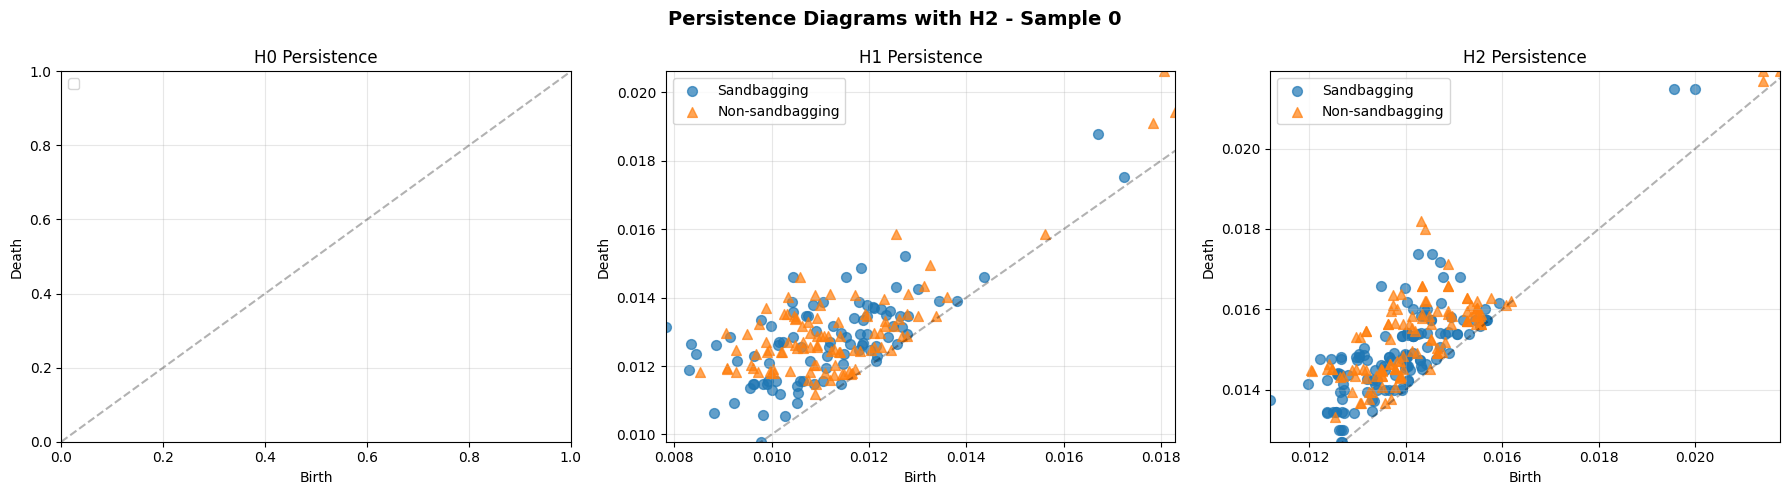


Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 20
  Samples with H2 features: 20
  Average H2 features: 1019.25
  Max H2 features: 4094
  Average H2 lifespan: 0.0006

Non-Sandbagging H2:

📊 H2 Statistics Summary:
  Total samples: 10
  Samples with H2 features: 10
  Average H2 features: 725.30
  Max H2 features: 2919
  Average H2 lifespan: 0.0009


In [6]:
# ==============================================================================
# USAGE EXAMPLES
# ==============================================================================

def example_usage(folder_path):
    """
    Examples of how to compute H2
    """
    
    # ========== EXAMPLE 1: Recompute from saved distances (FASTEST) ==========
    print("="*60)
    print("EXAMPLE 1: Recompute H2 from Saved Distance Matrices")
    print("="*60)
    print("This is the FASTEST method - uses already computed distance matrices\n")
    
    exp_dir = Path(folder_path)
    
    # Compute H2 for sandbagging condition
    res_list_s_h2 = compute_h2_from_saved_distances(
        exp_dir, 
        condition="sandbagging",
        save_results=True
    )
    
    # Compute H2 for non-sandbagging condition
    res_list_n_h2 = compute_h2_from_saved_distances(
        exp_dir,
        condition="non_sandbagging", 
        save_results=True
    )
    
    # Visualize
    visualize_h2_sample(res_list_s_h2, res_list_n_h2, sample_idx=0)
    
    # Analyze
    print("\nSandbagging H2:")
    analyze_h2_statistics(res_list_s_h2)
    
    print("\nNon-Sandbagging H2:")
    analyze_h2_statistics(res_list_n_h2)
    

if __name__ == "__main__":
    paths = [
        "/workspace/experiments/bert-base-uncased_bert_roberta", 
        "/workspace/experiments/distilbert-base-uncased",
        "/workspace/experiments/distilgpt2",
        "/workspace/experiments/google_electra-small-discriminator",
        "/workspace/experiments/roberta-base_bert_roberta"]
    for path in paths:
        example_usage(path)